# Grade: /100 pts

# Lab Assignment 05: Model Selection & Cross Validation

### You're a Data Scientist!
You are working as a Junior Data Scientist for a professional football (er, Soccer) club.  The owner of the team is very interested in seeing how the use of data can help improve the team's peformance, and perhaps win them a championship!

The draft is coming up soon (thats when you get to pick new players for your team), and the owner has asked you to create a model to help score potential draftees.  The model should look at attributes about the player and predict what their "rating" will be once they start playing professionally.

The football club's data team has provided you with data for 17,993 footballers from the league.  Your job: work with the Senior Data Scientist to build a model or models, perform model selection, and make predictions on players you have not yet seen.

### The Dataset

The data is stored in a csv file called `footballer_data.csv`.  The data contain 52 columns, including some information about the player, their skills, and their overall measure as an effective footballer.

Most features relate to the player's abilities in football related skills, such as passing, shooting, dribbling, etc.  Some features are rated on a 1-5 scale (5 being the best), others are rated on 0-100 (100 being the best), and others still are categorical (e.g. work rate is coded as low, medium, or high).

The target variable (or $y$ variable, if you will) is `overall`.  This is an overall measure of the footballer's skill and is rated from 0 to 100.  The most amazingly skilled footballer would be rated 100, where as I would struggle to score more than a 20. The model(s) you build should use the other features to predict `overall`.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


### Preliminaries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.stats as st

pd.set_option('display.max_columns', 500)

%matplotlib inline

#from sklearn.svm import SVC

### Question 1: /10pts

Read in the data and take a look at the dataframe.  There should be 52 columns. The outcome of interest is called `overall` which gives an overall measure of player performance. Not all of the other columns are particularly useful for modelling though (for instance, `ID` is just a unique identifier for the player.  This is essentially an arbitrary number and has no bearing on the player's rating).

The Senior Data Scientist thinks the following columns should be removed:

* ID
* club
* club_logo
* birth_date
* flag
* nationality
* photo
* potential

The Senior Data Scientist would also like the following columns converted into dummy variables:

* work_rate_att
* work_rate_def
* preferred_foot

Clean the data according to the Senior Data Scientist's instructions.

In [2]:
data = pd.read_csv("footballer_data.csv")

#dropping columns
data = data.drop(["ID", "club", "club_logo", "birth_date", "flag", "nationality", "photo", "potential"], axis=1)

#converting columns into dummy variables
data = pd.get_dummies(data, drop_first=True)
#data = pd.get_dummies(data, columns=["work_rate_att", "work_rate_def", "preferred_foot"])
data = data.drop([11760])
print(data)

       age  height_cm  weight_kg  overall  pac  sho  pas  dri  def  phy  \
0       32      185.0       80.0       94   90   93   82   90   33   80   
1       30      170.0       72.0       93   89   90   86   96   26   61   
2       25      175.0       68.0       92   92   84   79   95   30   60   
3       30      182.0       86.0       92   82   90   79   87   42   81   
4       31      193.0       92.0       92   91   90   95   89   60   91   
...    ...        ...        ...      ...  ...  ...  ...  ...  ...  ...   
11755   21      184.0       68.0       64   68   51   65   58   43   60   
11756   28      189.0       80.0       64   67   62   56   66   55   61   
11757   29      173.0       70.0       64   62   38   55   69   63   64   
11758   19      178.0       74.0       64   69   40   57   61   62   65   
11759   25      178.0       75.0       64   43   33   43   32   67   65   

       international_reputation  skill_moves  weak_foot  crossing  finishing  \
0                  

### Question 2: /10 pts

The data should all be numerical now. To evalute different models, define a function that returns the mean absolute error. Before we begin modelling, it is important to obtain a baseline for the accuracy of our predictive models. Compute the absolute errors resulting if we use the median of the `overall` variable to make predictions. This will serve as our baseline performance. Plot the distribution of the errors and print their mean and standard deviation.

Mean: 3.6904761904761907
STD: 3.1074163723327675


Text(0, 0.5, 'Error Amount')

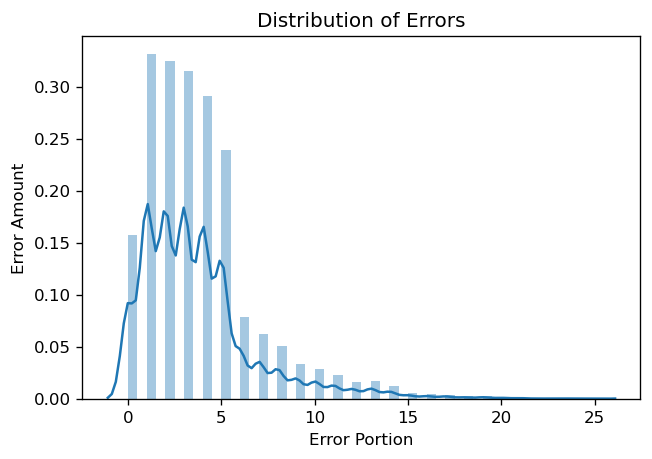

In [3]:
# Define mean absolute error function
def MAE (y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred)) #could've done len(y_true or y_pred)
    
# Get mean and std of test loss 
y = data.overall
y_median= y.median()
abs_error = np.abs(y-y_median)

mean = abs_error.mean()
std = abs_error.std()

# Plot distribution  
fig, ax = plt.subplots(dpi = 120)
sns.distplot(abs_error)
print(f"Mean: {mean}")
print(f"STD: {std}")

plt.title('Distribution of Errors') #adding a title to the plot
plt.xlabel("Error Portion") #x axis label
plt.ylabel("Error Amount") #y axis label

### Question 2: /15pts
To prepare the data for modelling, the Senior Data Scientist recomends you use `sklearn.model_selection.train_test_split` to seperate the data into a training set and a test set.

The Senior Data Scientist would like to estimate the performance of the final selected model to within +/- 0.25 units using mean absolute error as the loss function of choice.  

Using the formula for the effective test size ($n$) to get the precision to specific precision ($d$) relative to the test loss standard deviation of $\sigma_l$
$$ n = \left(\frac{1.96 \sigma_l}{d}\right)^2$$,

decide on an appropriate size for the test set, then use `train_test_split` to split the features and target variables into appropriate sets.

In [4]:
#split into train & test
X = data.drop("overall", axis="columns")

d =0.25 #specific precision
n = (1.96*std/d)**2
data_size = len(data)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = n/data_size, random_state = 0)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(11166, 45) (594, 45) (11166,) (594,)


### Question 4: /5pts
The Senior Data Scientist wants you to fit a linear regression to the data as a first model.  Use sklearn to build a model pipeline which fits a linear regression to the data. You can read up on sklearn pipelines [here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Note that the sklearn linear regression adds its own intercept so you don't need to create a column of 1s.

Text(0, 0.5, 'Error Amount')

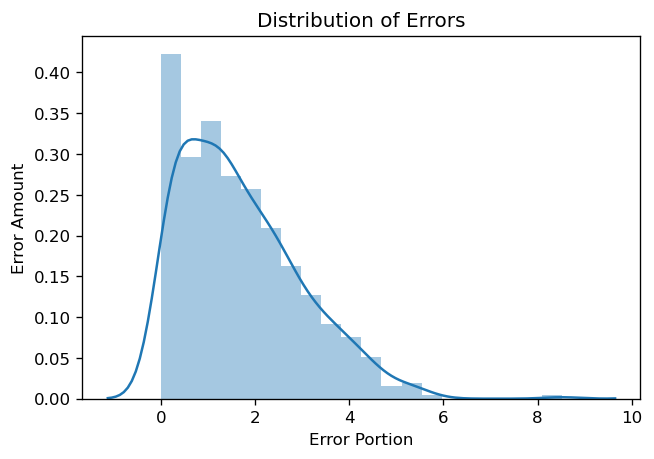

In [5]:
#build a pipeline model which fits a linear regression to the data
pipe_model = Pipeline(steps = [('linear regression', LinearRegression())])
pipe_model.fit(Xtrain, ytrain)

fig, ax = plt.subplots(dpi = 120)
LR_model = np.abs(ytest-pipe_model.predict(Xtest))
sns.distplot(LR_model)

plt.title('Distribution of Errors') #adding a title to the plot
plt.xlabel("Error Portion") #x axis label
plt.ylabel("Error Amount") #y axis label

### Question 5: /15pts

The senior data scientist wants a report of this model's cross validation score.  Use 5 fold cross validation to estimate the out of sample performance for this model, using your mean absolute error function from question 2.  

In [6]:
kf = KFold(n_splits=5,shuffle=False)
sc = make_scorer(MAE)
cv_scores = cross_val_score(pipe_model, Xtrain, ytrain, cv=kf, scoring=sc)
print(f"CV score: {cv_scores}")
print(f"CV loss: {cv_scores.mean()}")

CV score: [1.70105363 1.70948646 1.65374901 1.66848568 1.66463287]
CV loss: 1.6794815312104003


### Question 6: /15pts

That's impressive!  Your model seems to be very accurate, but now the Senior Data Scientist wants to try and make it more accurate.  Scouts have shared with the Senior Data Scientist that players hit their prime in their late 20s, and as they age they become worse overall.

The Senior Data Scientist wants to add a quadratic term for age to the model.  Repeat the steps above (creating a pipeline, validating the model, etc) for a model which includes a quadratic term for age. As in the Lab, include the addition of the quadratic term for Age as a Transform into the pipeline. 

CV score: [1.69397209 1.70174502 1.6455966  1.66731468 1.66292472]
CV loss: 1.674310623015278


Text(0, 0.5, 'Error Amount')

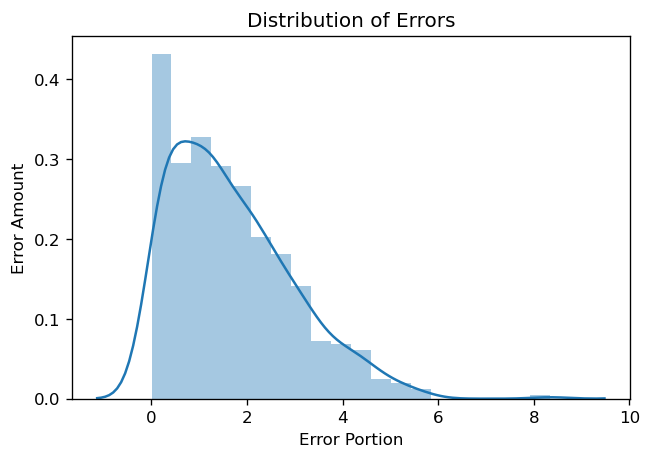

In [7]:
# Model 2: Squared trend for age
# Construct a new feature - age squared
# Model2 with costum transform (You can also use ColumnTransformer)
class Age2(BaseEstimator,TransformerMixin):  
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X = X.assign(age2 = X.age**2)
        return X
    
pipe_modelQUAD = Pipeline(steps = [('Age Squared', Age2()),('linear regression', LinearRegression())])
pipe_modelQUAD.fit(Xtrain, ytrain)

cv_scores = cross_val_score(pipe_modelQUAD, Xtrain, ytrain, cv=kf, scoring=sc)
print(f"CV score: {cv_scores}")
print(f"CV loss: {cv_scores.mean()}")

fig, ax = plt.subplots(dpi = 120)
LR_model = np.abs(ytest-pipe_modelQUAD.predict(Xtest))
sns.distplot(LR_model)

plt.title('Distribution of Errors') #adding a title to the plot
plt.xlabel("Error Portion") #x axis label
plt.ylabel("Error Amount") #y axis label

### Question 7: /10 pts


The Senior Data Scientist isn't too happy that the quadratic term has not improved the fit of the model much and now wants to include quadratic and interaction term for every feature (That's a total of 1080 features!!!!)

Add sklearn's `PolynomialFeatures` to your pipeline.  Report the cross validation score.

CV score: [0.85032765 0.80807531 0.82669291 0.84993848 0.86527051]
CV loss: 0.8400609728065744


Text(0, 0.5, 'Error Amount')

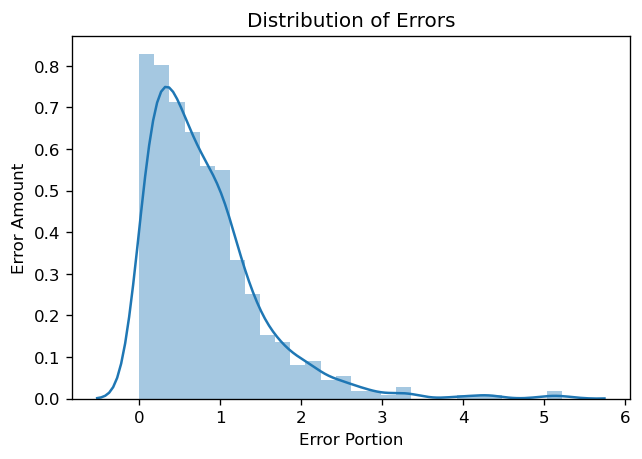

In [8]:
# Model 3: All polynomial features
pipe_modelPOLY = Pipeline(steps = [('Poly Features', PolynomialFeatures(degree=2)),('linear regression', LinearRegression())])
pipe_modelPOLY.fit(Xtrain, ytrain)

cv_scores = cross_val_score(pipe_modelPOLY, Xtrain, ytrain, cv=kf, scoring=sc)
print(f"CV score: {cv_scores}")
print(f"CV loss: {cv_scores.mean()}")

fig, ax = plt.subplots(dpi = 120)
LR_model = np.abs(ytest-pipe_modelPOLY.predict(Xtest))
sns.distplot(LR_model)

plt.title('Distribution of Errors') #adding a title to the plot
plt.xlabel("Error Portion") #x axis label
plt.ylabel("Error Amount") #y axis label

### Question 8: /10pts

The Senior Data Scientist is really happy with the results of adding every interaction into the model and wants to explore third order interactions (that is adding cubic terms to the model).

This is not a good idea!  Talk them down from the ledge.  Write them an email in the cell below explaining what could happen if you add too may interactions.

---

Hey Boss,

Hope you're doing well and staying safe. I wanted to discuss with you our current machine learning project. Although, the idea of adding third order interactions may seem like a great idea, since the last iteration worked so well, it is not. By doing this, it will add too many interactions to our model!! Too many interactions will result in more features than we have training data, which would be impossible to solve. While training error decreses, the test error will increase, due to overfitting. Additionally, it will be too computationally intensive that it may blow our computers...Its true what they say: Too much of a good thing can actually be a bad thing. 

Sincerly,

Jenna Wemple

Junior Data Scientist

### Question 9:  /10pts

You've successfully talked the Senior Data Scientist out of adding cubic terms to the model. Good job!

Based on the cross validation scores, which model would you choose?  
Train you model on all the training data. 
Estimate the performance of your chosen model on the test data you held out, and do the following:

- Compute a point estimate for the generalization error.
- Compute a confidence interval for the generalization error.  
- Plot the distribution of the absolute errors.

Is the test error close to the cross validation error of the model you chose? Why do you think this is the case?


Point Estimate: 0.8125238615894048
Confidence Interval: (0.06442260536892945, 2.0961625593437807)


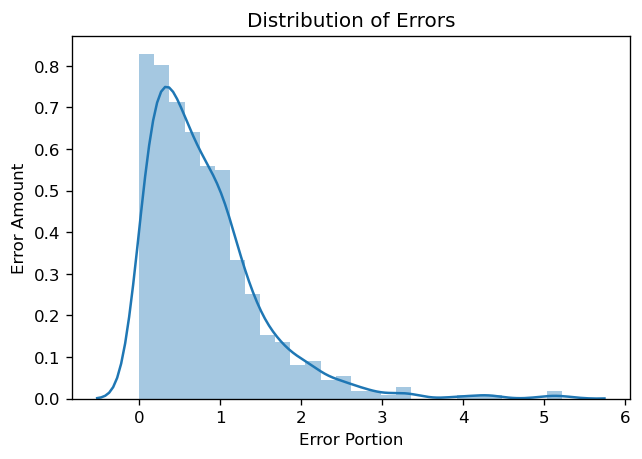

In [9]:
pipe_modelPOLY = Pipeline(steps = [('Poly Features', PolynomialFeatures(degree=2)),('linear regression', LinearRegression())])
pipe_modelPOLY.fit(Xtrain, ytrain)

y_predict = pipe_modelPOLY.predict(Xtest)
point_est = MAE(ytest, y_predict)

abs_error = np.abs(ytest-y_predict)
bounds = np.quantile(abs_error,[0.05,0.95])

#std = st.sem(abs_error)
#n = len(abs_error)
#alpha =0.95
#bounds = st.t.interval(alpha, n-1, point_est, std)

fig, ax = plt.subplots(dpi = 120)
LR_model= np.abs(ytest-y_predict)
sns.distplot(LR_model)

plt.title('Distribution of Errors') #adding a title to the plot
plt.xlabel("Error Portion") #x axis label
plt.ylabel("Error Amount") #y axis label

print(f"Point Estimate: {point_est}")
print(f"Confidence Interval: {bounds[0], bounds[1]}")

The model that I would choose would be Model3, which included the PolynomialFeatures
in our pipeline. It has the lowest score, and that is why I choose it. 

The test error is very close to the cross validation error of model #3 
The test error was 0.812 and the CV error was 0.840. I think this is the 
case because our model has improved so much from the start, that it is
almost identical to the "ideal" model error obtained by our training 
data. The CV score is an estimate of the test error, but it simply uses
the training data instead of the testing data.

### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.